In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image 
from scipy import ndimage, misc
import matplotlib.pyplot as plt

from image_feature_extractor import Img2Vec

from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing

import seaborn as sns



# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Useful functions

In [3]:
def apply_contrast(images_data, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images_data]
    images = torch.stack(images_list)
    contrasted_images = F.adjust_contrast(images, contrast_factor)
    contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in contrasted_images]))
    return contrasted_images

def apply_rotation(images_data, angle):
    rotated_images = []
    for img in images_data:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        rotated_images.append(rotated_image)
    rotated_images = np.array(rotated_images)
    return rotated_images


# Generate a list of original and modified images: every original image has a duplicate which is 
# the modified original image.
def generate_duplicates_modified_original(image_set, mod_factor, mod_type="contrast"):
    original_labels = np.zeros(len(image_set.data))
    modified_labels = np.ones(len(image_set.data))
    
    modified_images = None
    
    if mod_type=="contrast":
        modified_images = apply_contrast(image_set.data, mod_factor) 
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(image_set.data, mod_factor)

    original_and_modified_images = np.concatenate((image_set.data, modified_images), axis=0)
    modification_labels = np.concatenate((original_labels, modified_labels), axis=None)
    image_labels = np.concatenate((image_set.targets, image_set.targets), axis=None)        
    return modified_images, original_and_modified_images, modification_labels, image_labels


# used to binarize the target variable
def binarize(y):    
    y = np.copy(y) > 5
    return y.astype(int)

def correlate_label_with_img_modification(image_dataset, mod_factor, mod_percent= 0.1, 
                                          binarize_label=True, mod_type="contrast"):
    y = binarize(image_dataset.targets)
    mod_labels = np.logical_xor(y, np.random.binomial(1, mod_percent, size=len(y)))
    
    images_to_be_modified = image_dataset.data[mod_labels]
    images_to_be_left_alone = image_dataset.data[~mod_labels]
    
    all_img_labels = None
    
    if binarize_label:
        modified_imgs_labels = y[mod_labels]
        unmodified_imgs_labels = y[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)
    else:
        modified_imgs_labels = np.array(image_dataset.targets)[mod_labels]
        unmodified_imgs_labels = np.array(image_dataset.targets)[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)    
    
    all_images = None
    
    if mod_type == "contrast":
        modified_images = apply_contrast(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)                    
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)
        
    return all_images, all_img_labels, mod_labels.astype(int)


# Function to extract image features    
def get_features(images, batch_size):
    Z_list = []
    img2vec = Img2Vec(model="resnet50")
#     img2vec = Img2Vec()
    for first in range(0, len(images), batch_size):
        images_subset = images[first:first+batch_size]
        Z_subset = img2vec.get_vec(images_subset)
        Z_list.append(Z_subset)
    Z = np.vstack(Z_list)
    return Z

# Accuracies for different variations of data distributions per class

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lilianngweta. Use `wandb login --relogin` to force relogin


 Results for contrast factor:  0.1


 Results for alpha value:  0.5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.81588
LR Accuracy on test data - Z - In Dist:  0.7941
LR Accuracy on test data - Z - OOD:  0.7927



 Results for alpha value:  0.75


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.81298
LR Accuracy on test data - Z - In Dist:  0.7921
LR Accuracy on test data - Z - OOD:  0.7575



 Results for alpha value:  0.9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.82972
LR Accuracy on test data - Z - In Dist:  0.8161
LR Accuracy on test data - Z - OOD:  0.624



 Results for alpha value:  0.95


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.84316
LR Accuracy on test data - Z - In Dist:  0.8256
LR Accuracy on test data - Z - OOD:  0.5053



 Results for alpha value:  0.99


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.85806
LR Accuracy on test data - Z - In Dist:  0.8439
LR Accuracy on test data - Z - OOD:  0.3069



 Results for alpha value:  1.0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.86714
LR Accuracy on test data - Z - In Dist:  0.8542
LR Accuracy on test data - Z - OOD:  0.0036








 Results for contrast factor:  0.3


 Results for alpha value:  0.5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.8881
LR Accuracy on test data - Z - In Dist:  0.8593
LR Accuracy on test data - Z - OOD:  0.8618



 Results for alpha value:  0.75


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.88914
LR Accuracy on test data - Z - In Dist:  0.8626
LR Accuracy on test data - Z - OOD:  0.837



 Results for alpha value:  0.9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.90238
LR Accuracy on test data - Z - In Dist:  0.8776
LR Accuracy on test data - Z - OOD:  0.751



 Results for alpha value:  0.95


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.91102
LR Accuracy on test data - Z - In Dist:  0.8865
LR Accuracy on test data - Z - OOD:  0.6715



 Results for alpha value:  0.99


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.9223
LR Accuracy on test data - Z - In Dist:  0.9019
LR Accuracy on test data - Z - OOD:  0.4661



 Results for alpha value:  1.0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92894
LR Accuracy on test data - Z - In Dist:  0.9082
LR Accuracy on test data - Z - OOD:  0.1366








 Results for contrast factor:  0.5


 Results for alpha value:  0.5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.91118
LR Accuracy on test data - Z - In Dist:  0.8831
LR Accuracy on test data - Z - OOD:  0.8806



 Results for alpha value:  0.75


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.91548
LR Accuracy on test data - Z - In Dist:  0.8854
LR Accuracy on test data - Z - OOD:  0.8661



 Results for alpha value:  0.9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92394
LR Accuracy on test data - Z - In Dist:  0.8961
LR Accuracy on test data - Z - OOD:  0.808



 Results for alpha value:  0.95


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93012
LR Accuracy on test data - Z - In Dist:  0.9041
LR Accuracy on test data - Z - OOD:  0.7519



 Results for alpha value:  0.99


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93962
LR Accuracy on test data - Z - In Dist:  0.9137
LR Accuracy on test data - Z - OOD:  0.6122



 Results for alpha value:  1.0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.9421
LR Accuracy on test data - Z - In Dist:  0.9168
LR Accuracy on test data - Z - OOD:  0.4532








 Results for contrast factor:  0.7


 Results for alpha value:  0.5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92216
LR Accuracy on test data - Z - In Dist:  0.8917
LR Accuracy on test data - Z - OOD:  0.8926



 Results for alpha value:  0.75


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92524
LR Accuracy on test data - Z - In Dist:  0.8945
LR Accuracy on test data - Z - OOD:  0.8812



 Results for alpha value:  0.9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92968
LR Accuracy on test data - Z - In Dist:  0.9024
LR Accuracy on test data - Z - OOD:  0.8503



 Results for alpha value:  0.95


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93374
LR Accuracy on test data - Z - In Dist:  0.9052
LR Accuracy on test data - Z - OOD:  0.831



 Results for alpha value:  0.99


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93872
LR Accuracy on test data - Z - In Dist:  0.9114
LR Accuracy on test data - Z - OOD:  0.7953



 Results for alpha value:  1.0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93978
LR Accuracy on test data - Z - In Dist:  0.9104
LR Accuracy on test data - Z - OOD:  0.7761








 Results for contrast factor:  0.9


 Results for alpha value:  0.5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92552
LR Accuracy on test data - Z - In Dist:  0.8986
LR Accuracy on test data - Z - OOD:  0.8988



 Results for alpha value:  0.75


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92724
LR Accuracy on test data - Z - In Dist:  0.8989
LR Accuracy on test data - Z - OOD:  0.8979



 Results for alpha value:  0.9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92754
LR Accuracy on test data - Z - In Dist:  0.9011
LR Accuracy on test data - Z - OOD:  0.8924



 Results for alpha value:  0.95


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92826
LR Accuracy on test data - Z - In Dist:  0.9005
LR Accuracy on test data - Z - OOD:  0.8927



 Results for alpha value:  0.99


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.9282
LR Accuracy on test data - Z - In Dist:  0.9021
LR Accuracy on test data - Z - OOD:  0.892



 Results for alpha value:  1.0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92816
LR Accuracy on test data - Z - In Dist:  0.9013
LR Accuracy on test data - Z - OOD:  0.8902








 Results for contrast factor:  2


 Results for alpha value:  0.5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.90706
LR Accuracy on test data - Z - In Dist:  0.8778
LR Accuracy on test data - Z - OOD:  0.8775



 Results for alpha value:  0.75


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.91032
LR Accuracy on test data - Z - In Dist:  0.8861
LR Accuracy on test data - Z - OOD:  0.8607



 Results for alpha value:  0.9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.91798
LR Accuracy on test data - Z - In Dist:  0.8964
LR Accuracy on test data - Z - OOD:  0.8029



 Results for alpha value:  0.95


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.92544
LR Accuracy on test data - Z - In Dist:  0.9001
LR Accuracy on test data - Z - OOD:  0.7533



 Results for alpha value:  0.99


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93354
LR Accuracy on test data - Z - In Dist:  0.913
LR Accuracy on test data - Z - OOD:  0.6147



 Results for alpha value:  1.0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.93684
LR Accuracy on test data - Z - In Dist:  0.9167
LR Accuracy on test data - Z - OOD:  0.5159










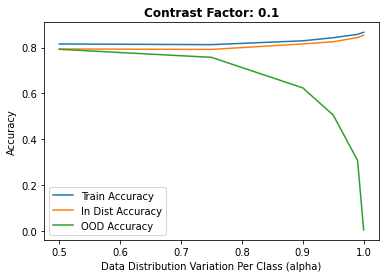

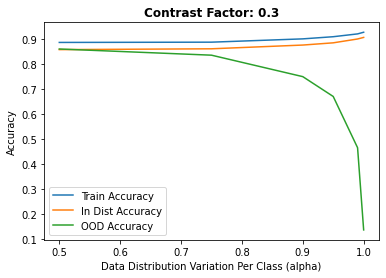

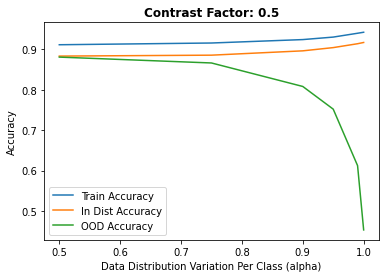

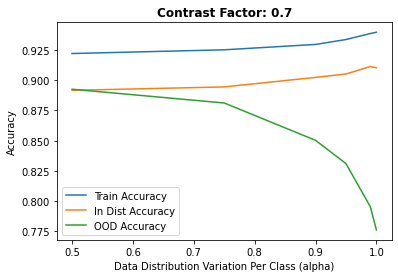

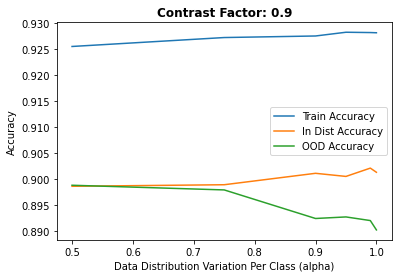

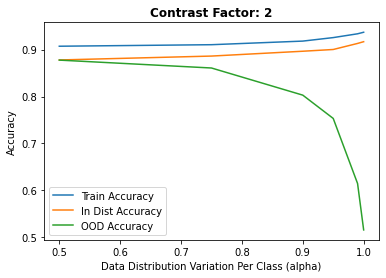

In [4]:
# contrast_factor: 0 gray - 1 original image - 2 increases the contrast by a factor of 2.
# contrast_factor = 0.3
angle = 70
batch_size = 64

rotation_angles = [15,30,45,60,75,90,105,120,135,150,165,180]
contrast_factors = [0.1, 0.3,0.5,0.7,0.9,2]
distributions = [0.5, 0.75, 0.90, 0.95, 0.99,1.0]

import wandb

wandb.login()


for contrast_factor in contrast_factors:
    print(" Results for contrast factor: ", contrast_factor)

    accuracy0_list = []
    accuracy1_list = []
    accuracy2_list = []

    labels0 = []
    labels1 = []
    labels2 = []
    
    wandb.init(project="accuracy-vs-dist-variations", entity="lilianngweta")
    
    for dist_value in distributions:
        print(" Results for alpha value: ", dist_value)
        # Creating sets of images in a way that correlates the way images are modified with label
        train_imgs, train_labels2, train_mod_labels2 = correlate_label_with_img_modification(
            train_dataset, contrast_factor, mod_percent= dist_value, binarize_label=False, mod_type="contrast")

        test_imgs_indist, test_labels2_indist, test_mod_labels2_indist = correlate_label_with_img_modification(
            test_dataset, contrast_factor, mod_percent= dist_value, binarize_label=False, mod_type="contrast")

        test_imgs_ood, test_labels2_ood, test_mod_labels2_ood = correlate_label_with_img_modification(
            test_dataset, contrast_factor, mod_percent= 1-dist_value, binarize_label=False, mod_type="contrast")


        # Extract image features
        Z_train = get_features(train_imgs, batch_size)
        Z_test_indist= get_features(test_imgs_indist, batch_size)
        Z_test_ood= get_features(test_imgs_ood, batch_size)


        # Classification and recording prediction accuracy
        logistic_regression_model2 = LogisticRegression(
            multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_train, 
                                                                           train_labels2)
        accuracy0 = logistic_regression_model2.score(Z_train, train_labels2)
        accuracy1 = logistic_regression_model2.score(Z_test_indist, test_labels2_indist)
        accuracy2 = logistic_regression_model2.score(Z_test_ood, test_labels2_ood)
        accuracy0_list.append(accuracy0)
        accuracy1_list.append(accuracy1)
        accuracy2_list.append(accuracy2)

        labels0.append("Train Accuracy")
        labels1.append("In Dist Accuracy")
        labels2.append("OOD Accuracy")

        print('LR Training Accuracy: ', accuracy0)
        print('LR Accuracy on test data - Z - In Dist: ', accuracy1)
        print('LR Accuracy on test data - Z - OOD: ', accuracy2)
        print("\n"*2)

    x= distributions
    y = np.array([accuracy0_list, accuracy1_list, accuracy2_list]).T
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Data Distribution Variation Per Class (alpha)")
    ax.legend(["Train Accuracy", "In Dist Accuracy", "OOD Accuracy"])
    ax.set_title("Contrast Factor: "+str(contrast_factor), fontweight ="bold")

    # Log the plot
    wandb.log({"Accuracy vs alpha plots - labels binarized": wandb.Image(fig)})
    

    print("\n"*4)    
wandb.finish()


In [5]:
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt

# labels0 = ["Train Accuracy","Train Accuracy","Train Accuracy","Train Accuracy","Train Accuracy","Train Accuracy"]
# labels1 = ["In Dist Accuracy","In Dist Accuracy","In Dist Accuracy","In Dist Accuracy","In Dist Accuracy","In Dist Accuracy"]
# labels2 = ["OOD Accuracy","OOD Accuracy","OOD Accuracy","OOD Accuracy","OOD Accuracy","OOD Accuracy"]
# contrast_factor = 0.3
# accuracy0_list = [0.92736, 0.92682, 0.92744,0.92736, 0.92682, 0.92744]
# accuracy1_list = [0.8991, 0.9019, 0.9013,0.8991, 0.9019, 0.9013]
# accuracy2_list = [0.8987, 0.8981, 0.8932,0.8987, 0.8981, 0.8932]
# distributions = [0.5, 0.75, 0.90, 0.95, 0.99,1.0]
# # alpha = np.concatenate((distributions, distributions,distributions), axis=None)
# # accuracies=np.concatenate((accuracy0_list, accuracy1_list, accuracy2_list), axis=None)
# # key = np.concatenate((labels0, labels1, labels2), axis=None)
# # len(key)
# # key

# # plt.rc('axes', labelsize=15)
# # plt.rc('xtick', labelsize=15)
# # plt.rc('ytick', labelsize=15)
# # sns.set_palette(sns.mpl_palette('Greys_r', 2))
# # #     sns.set_style("whitegrid")
# # f, (ax1) = plt.subplots(1, 1, figsize=(7, 6), sharex=True)
# # sns.set(style="ticks", color_codes=False)
# # #     ax.bar_label(ax.containers[0])
# # g = sns.lineplot(x=alpha, y=accuracies, hue=key, ax=ax1)
# # #     g = sns.relplot(data=data, x="Thresholds", y="KL Divergence", hue="Feature Type", kind='line')
# # #     g = sns.barplot(x="Thresholds", y="KL Divergence", hue="Feature Type", data=data, ax=ax1)
# # plt.legend(loc='lower right')
# # #     ax1.bar_label(ax1.containers[0])
# # g.set(xlabel='Threshold Values', ylabel='KL Divergence Values in Log Scale')
# # # g.set_yscale("log")
# # #     g.set_title('Multi-label Classification Results',fontdict= { 'fontsize': 40, 'fontweight':'bold'})
# #     plt.tight_layout()

# import wandb

# wandb.login()


# # with :
# for i in range(3):
#     wandb.init(project="accuracy-vs-dist-variations", entity="lilianngweta")
#     x= distributions
#     y = np.array([accuracy0_list, accuracy1_list, accuracy2_list]).T
#     fig, ax = plt.subplots()
#     ax.plot(x, y)
#     ax.set_ylabel("Accuracy")
#     ax.set_xlabel("Data Distribution Variation Per Class (alpha)")
#     ax.legend(["Train Accuracy", "In Dist Accuracy", "OOD Accuracy"])
#     ax.set_title("Contrast Factor: "+str(contrast_factor), fontweight ="bold")

#     # Log the plot
#     wandb.log({"Accuracy vs alpha plots": wandb.Image(fig)})
#     wandb.finish()
#     fig
    



In [6]:
# import matplotlib.pyplot as plt
# # Unique category labels: 'D', 'F', 'G', ...
# # color_labels = key.unique()

# # List of RGB triplets
# # rgb_values = sns.color_palette("Set2", 8)

# # Map label to RGB
# # color_map = dict(zip(color_labels, rgb_values))

# # Finally use the mapped values
# # plt.plot(alpha, accuracies)




# g = sns.lineplot(x=alpha, y=accuracies, hue=key)
# g.set(xlabel='Data Distribution Variation Per Class (alpha)', ylabel='Accuracy')
# plt.show()

In [7]:
# # import matplotlib.pyplot as plt
# # %matplotlib inline

# # Make the plot
# # fibonacci = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
# wandb.init(project="accuracy-vs-dist-variations", entity="lilianngweta")
# x= distributions
# y = np.array([accuracy0_list, accuracy1_list, accuracy2_list]).T
# fig, ax = plt.subplots()
# ax.plot(x, y)
# ax.set_ylabel("Accuracy")
# ax.set_xlabel("Data Distribution Variation Per Class (alpha)")
# ax.legend(["Train Accuracy", "In Dist Accuracy", "OOD Accuracy"])

# # Log the plot
# # wandb.log({"plot": fig})
# wandb.finish()
# fig

In [8]:
# with wandb.init(project="accuracy-vs-dist-variations", entity="lilianngweta"):
#     x= distributions
#     y = np.array([accuracy0_list, accuracy1_list, accuracy2_list]).T
#     fig, ax = plt.subplots()
#     ax.plot(x, y)
#     ax.set_ylabel("Accuracy")
#     ax.set_xlabel("Data Distribution Variation Per Class (alpha)")
#     ax.legend(["Train Accuracy", "In Dist Accuracy", "OOD Accuracy"])

#     # Log the plot
#     wandb.log({"plot": fig})
#     wandb.finish()
#     fig
    

# # wandb.log({"Contrast Factor: "+str(contrast_factor): fig})
# wandb.log({"Contrast Factor": fig})